In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
outputF=False

In [3]:
toCompute=True

In [4]:
n_pred=5

In [5]:
dataset_name="adult"

In [6]:
dirO="./out/out_{dataset_name}_v1"
outputdir=dirO

# Import dataset

In [7]:
from src.import_datasets import import_process_adult
risk_class_type=False
dfI =import_process_adult()
dfI.reset_index(drop=True, inplace=True)
df=dfI.copy()
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,class
0,25,Private,Dropout,Never-Married,Blue-Collar,Own-child,Black,Male,0,0,40,<=50K
1,38,Private,High School grad,Married,Blue-Collar,Husband,White,Male,0,0,50,<=50K
2,28,Local-gov,Associates,Married,Other,Husband,White,Male,0,0,40,>50K
3,44,Private,High School grad,Married,Blue-Collar,Husband,Black,Male,7688,0,40,>50K
4,34,Private,Dropout,Never-Married,Service,Not-in-family,White,Male,0,0,30,<=50K


In [8]:
from ProcessedDataset import ProcessedDataset

In [9]:
all_data=True
pc = ProcessedDataset(df)

from sklearn.ensemble import RandomForestClassifier
clf_init = RandomForestClassifier(random_state=42)
pc.processDataset(clf_init, all_data=False, dataset_name=dataset_name)

In [10]:
predicted=np.argmax(pc.predict_fn(pc.test.values), axis=1)
mispredicted=[i for i,p in enumerate(predicted) if p!=pc.labels_test[i]]
correct_prediction=[i for i,p in enumerate(predicted) if p==pc.labels_test[i]]

In [11]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", round(accuracy_score(pc.labels_test, predicted),4))

Accuracy:  0.8392


# LIME

In [12]:
import lime
import lime.lime_tabular
np.random.seed(1)

In [13]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(pc.train.values ,feature_names = pc.feature_names,class_names=pc.class_names,
                                                   categorical_features=pc.categorical_features_pos, 
                                                   categorical_names=pc.categorical_names_LE, kernel_width=3)

# SHAP

In [14]:
if toCompute:
    import shap

    shap_explainer = shap.TreeExplainer(pc.clf)
    #explainer = shap.KernelExplainer(predict_fn, OH_X_train.values, link="logit")

    shap_values = shap_explainer.shap_values(pc.OH_X_test_cols.iloc[0:1])
    #shap_values = explainer.shap_values(OH_X_test_cols.iloc[0:5])

# Anchor

In [15]:
from anchor import utils
from anchor import anchor_tabular

In [16]:
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    pc.class_names,
    pc.feature_names,
    pc.train.values,
    pc.categorical_names_LE)

# LACE

In [17]:
from src.LACE_explainer import LACE_explainer

lace_explainer = LACE_explainer(pc.d_train,pc.predict_fn, dataset_name="COMPAS")

# Comparison

LIME
SHAP
Id 100
Anchor: education = Dropout AND marital-status = Never-Married
Predicted class:  0
Precision: 0.96
Coverage: 0.05
{'Rule_1': (['workclass=Private', 'education=Dropout', 'marital-status=Never-Married', 'occupation=Blue-Collar', 'capital-gain=0'], '-->', '<=50K'), 'Rule_2': (['workclass=Private', 'education=Dropout', 'marital-status=Never-Married', 'race=White'], '-->', '<=50K'), 'Rule_3': (['workclass=Private', 'education=Dropout', 'marital-status=Never-Married', 'capital-gain=0'], '-->', '<=50K'), 'Rule_4': (['workclass=Private', 'education=Dropout', 'occupation=Blue-Collar', 'race=White'], '-->', '<=50K'), 'Rule_5': (['workclass=Private', 'education=Dropout', 'occupation=Blue-Collar', 'capital-gain=0'], '-->', '<=50K'), 'Rule_6': (['workclass=Private', 'marital-status=Never-Married', 'occupation=Blue-Collar', 'capital-gain=0', 'capital-loss=0'], '-->', '<=50K'), 'Rule_7': (['workclass=Private', 'occupation=Blue-Collar', 'race=White', 'capital-loss=0'], '-->', '<=50K')

TypeError: cannot unpack non-iterable Figure object

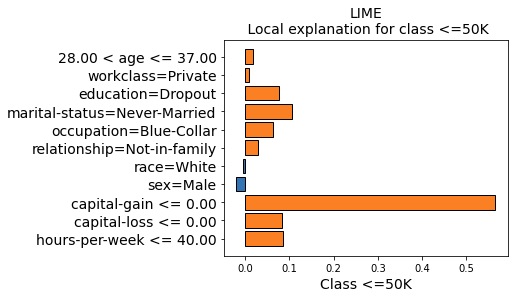

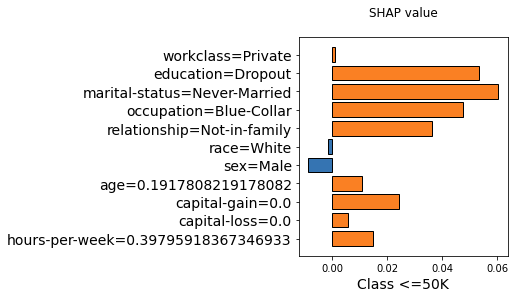

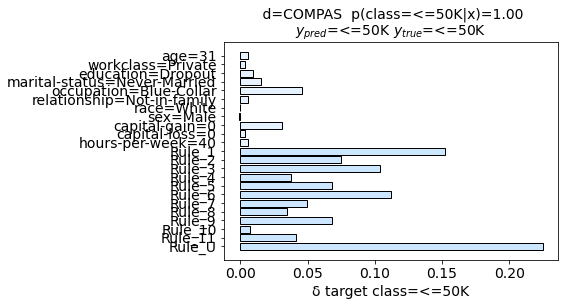

In [18]:
for id_i in [100]:
    from utils_RW import plot_lime_explanation
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    print("LIME")
    exp = lime_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn, num_features=len(pc.feature_names), labels=[predicted_class])
    fig_lime = plot_lime_explanation(exp, label=predicted_class, pred=pc.class_names[np.argmax(pc.predict_fn(pc.test.iloc[id_i:id_i+1].values))], true_label=pc.class_names[pc.labels_test[id_i]])
    fig_lime.set_size_inches(7.25, 4.25)
    fig_lime.tight_layout()
    
    
    from utils_RW import sumCategories, plotShapValues, convertInstance
    print("SHAP")
    instance=pc.OH_X_test_cols.iloc[id_i]
    shap_values = shap_explainer.shap_values(instance)
    matching_instance=convertInstance(instance, pc.categorical_features, pc.continuos_features)

    sum_shap_for_categories=sumCategories(shap_values[predicted_class], pc.oh_columns, pc.categorical_features, matching_instance)
    fig_shap=plotShapValues(list(sum_shap_for_categories.values()), list(sum_shap_for_categories.keys()), target_class=pc.class_names[predicted_class], \
                   pred=pc.class_names[pc.clf.predict([instance])[0]], true=pc.class_names[pc.labels_test[id_i]])
    fig_shap.set_size_inches(7.25, 4.25)
    fig_shap.tight_layout()
 
    from utils_RW import printAnchor, dictAnchor
    exp = anchor_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn_class, threshold=0.95)
    printAnchor(id_i, exp)
    dictAnchor(id_i, exp)
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        verbose=False)
    fig_lace, _=explanation_fm.plotExplanation(showRuleKey=False, retFig=True)
    explanation_fm.local_rules.printLocalRules()

What-if analysis

In [19]:
from interactive import interactiveAttributeLevelInspection

SelectMultiple(description='Feature', index=(0,), options=('age', 'workclass', 'education', 'marital-status', …

Button(description='Select attributes', style=ButtonStyle())

SelectionSlider(continuous_update=False, description='occupation', index=1, options=('Admin', 'Blue-Collar', '…

{}


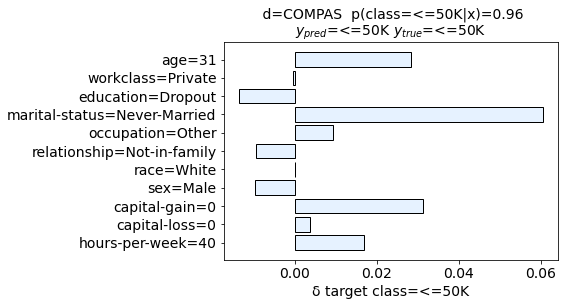

{}


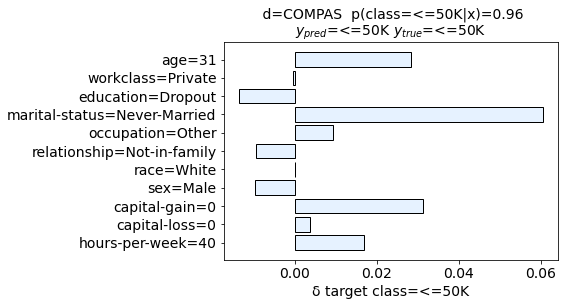

In [21]:
instance=explanation_fm.encoded_instance
predicted_class=pc.predict_fn_class(instance.values.reshape(1,-1))[0]
target_class_decoded=pc.class_names[predicted_class]
explanation_fm.interactiveAttributeLevelInspectionExp(target_class_decoded)